In [ ]:
# # return the top 30 most popular movies to use as the prompt for user ratings
# output_file = 'recs-app/public/top_rated_movies30.json'

# top_rated_movies.sort_values(by='Count', ascending=False, inplace=True)
# top_rated_movies_names = top_rated_movies.index.values
# top_rated_movies_slice = top_rated_movies.head(10)
# top_rated_movies_slice.columns = top_rated_movies_slice.columns.get_level_values(0)
# print(top_rated_movies)

# top_rated_movies_slice.to_json(output_file, orient='index')


In [1]:
from movie_recommender import MovieRecommender


movies_file = 'data/ml-10M100K/movies.dat'
ratings_file = 'data/ml-10M100K/ratings.dat'
movie_rec = MovieRecommender(movies_filename=movies_file, ratings_filename=ratings_file)

<class 'matplotlib.axes._subplots.AxesSubplot'>


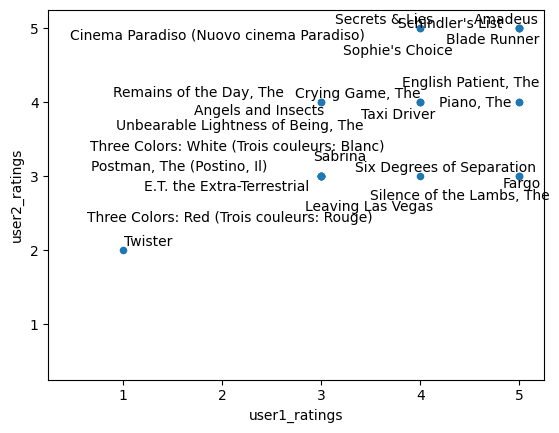

In [8]:
movie_rec.plot_users_ratings(5, 10)

In [40]:
# split genres column by the '|' character
genres = movie_rec.movies_df.genres.apply(lambda genres: genres.split('|')).values

# double list comprehension to flatten lists of genres
unique_genres = set([genre for genre_list in genres for genre in genre_list])
print(unique_genres)

# one movie has no genre associated
num_movies_no_genre = movie_rec.movies_df[movie_rec.movies_df.genres == '(no genres listed)'].name.count()
print(f'found {num_movies_no_genre} movies with (no genre listed)')
for row in movie_rec.movies_df.loc[movie_rec.movies_df.genres == '(no genres listed)'].name:
    print(row)


{'Film-Noir', 'Comedy', 'Romance', 'Fantasy', '(no genres listed)', 'Adventure', 'Documentary', 'Sci-Fi', 'War', 'Action', 'Musical', 'Western', 'Horror', 'Crime', 'Mystery', 'Children', 'Drama', 'Thriller', 'IMAX', 'Animation'}
found 1 movies with (no genre listed)
Pull My Daisy (1958)


In [ ]:
movie_rec.handle_recommendation_request(liked_movies=(1, 2, 19, 34), disliked_movies=())

In [5]:
movie_rec.top_rated_movies.sort_values(
            by='Count', ascending=False, inplace=True)
top_rated_movies_names = movie_rec.top_rated_movies.index.values
length = 500
movie_rec.top_rated_movies_slice = movie_rec.top_rated_movies.head(length)
movie_rec.top_rated_movies_slice.columns = movie_rec.top_rated_movies_slice.columns.get_level_values(0)
print(movie_rec.top_rated_movies_slice.columns)
movie_rec.top_rated_movies_slice = movie_rec.top_rated_movies_slice.drop('rating', axis=1)
# Define a lambda function to get the movie_id for a given movie name
get_movie_id = lambda movie_name: movie_rec.movies_df[movie_rec.movies_df['name'] == movie_name].index.values[0]

# Apply the lambda function to each row of the DataFrame to set the movie_id
movie_rec.top_rated_movies_slice['movie_id'] = movie_rec.top_rated_movies_slice.index.map(get_movie_id)
movie_rec.top_rated_movies_slice['title'] = movie_rec.top_rated_movies_slice.index
movie_rec.top_rated_movies_slice = movie_rec.top_rated_movies_slice.set_index('movie_id')

print(movie_rec.top_rated_movies_slice)
output_file='data/top_rated_{}.json'.format(length)

movie_rec.top_rated_movies_slice.to_json(output_file, orient='index')

NameError: name 'movie_rec' is not defined

In [ ]:
from urllib.parse import quote
from urllib3 import disable_warnings
from urllib3.exceptions import InsecureRequestWarning
import requests
import bs4

def pull_movie_poster(movie_id: int) -> None:
    try:
        disable_warnings(InsecureRequestWarning)
        title = movie_rec.get_movie_title_with_year(movie_id)
        clean_title = movie_rec.get_movie_title(movie_id)
        base_url = 'https://imdb.com/find/?q='
        base_page_url = 'https://imdb.com'
        qs_title = quote(title)
        url = base_url + qs_title + '&ref_=nv_sr_sm'
        headers = requests.utils.default_headers()
        headers.update({'User-Agent': 'My User Agent 2.0',})

        print(f'search page: {url}')
        html = requests.get(url, verify=False, headers=headers).content
        soup = bs4.BeautifulSoup(html, 'lxml')
        find_title_results = soup.find_all('li', {'class': 'find-title-result'})
        for tr in find_title_results:
            div_title = tr.find_all(
                'a', {'class': 'ipc-metadata-list-summary-item__t'})
            for dt in div_title:
                # this may need a more clever way of filtering if the wrong movie posters are getting pulled
                if dt.text == clean_title or ',' in clean_title or True:
                    full_page = tr.find('a')['href']
                    full_page_html = requests.get(
                        base_page_url+full_page, verify=False, headers=headers).content
                    full_page_soup = bs4.BeautifulSoup(full_page_html, 'lxml')
                    img = full_page_soup.find('img', {'class': 'ipc-image'})
                    if img:
                        if img['src']:
                            response = requests.get(img['src'], verify=False)
                            img_content = response.content
                            with open('data/posters/'+str(movie_id)+'.jpg', 'wb') as f:
                                print(f'writing image {clean_title}')
                                f.write(img_content)
                                return
                        else:
                            print('no image source found')
                    else:
                        print('no image found')
                else:
                    print(f'mismatching title and listed name: {dt.text} != {clean_title}')
    except Exception as e:
        print(e)



In [ ]:
import pandas as pd

# movie_rec.output_to_json()
top30_input_filepath = 'data/top_rated_250.json'
top30_filepath = 'recs-app/public/top_rated_movies30.archive.json'
top30_df = pd.read_json(top30_input_filepath)
top30_df = top30_df.T
get_movie_id = lambda movie_name: movie_rec.movies_df[movie_rec.movies_df['name'] == movie_name].index.values[0]

# Apply the lambda function to each row of the DataFrame to set the movie_id
top30_df['movie_id'] = top30_df['title'].map(get_movie_id)
top30_df.to_json(top30_filepath, orient="index")
for name in top30_df['title'][10:]:
    pull_movie_poster(top30_df.loc[top30_df['title'] == name]['movie_id'].values[0])
# print(top30_df.T)


In [ ]:
g = movie_rec.get_movie_genres(1)
print(g)

In [ ]:
import numpy as np


# return the difference between average ratings for two movies
def get_movie_mean_rating_error(movie1_id: int, movie2_id: int):
    movie1_ratings = np.mean(
        movie_rec.ratings_df.loc[movie_rec.ratings_df.index == movie1_id]['rating'].values)
    movie2_ratings = np.mean(
        movie_rec.ratings_df.loc[movie_rec.ratings_df.index == movie2_id]['rating'].values)
    return abs(movie1_ratings - movie2_ratings)


# get_movie_mean_rating_error(599, 700)
# movie_rec.get_movie_users(5)
print(movie_rec.get_movie_title(1))
print(movie_rec.get_movie_title(2))
print(len(movie_rec.get_movie_users(1)))
print(len(movie_rec.get_movie_users(2)))
print(len(movie_rec.get_common_users(1, 2)))

In [ ]:
def get_movie_rating_pearson_coeff(movie1_id: int, movie2_id: int)-> float:
    common_users = movie_rec.get_common_users(movie1_id=movie1_id, movie2_id=movie2_id)
    movie1_ratings = [movie_rec.get_user_movie_rating(user_id=u, movie_id=movie1_id) for u in common_users]
    movie2_ratings = [movie_rec.get_user_movie_rating(user_id=u, movie_id=movie2_id) for u in common_users]
    coeff = np.corrcoef(np.array(movie1_ratings), np.array(movie2_ratings))[0, 1]
    movie1_title = movie_rec.get_movie_title(movie1_id)
    movie2_title = movie_rec.get_movie_title(movie2_id)
    print(f'{movie1_title} and {movie2_title} have a correlation of {"{:.2f}".format(coeff)} from {len(common_users)} users who have rated both')

get_movie_rating_pearson_coeff(1, 3)

In [ ]:
from urllib.parse import quote
import requests
import bs4

movie_id = 1
title = movie_rec.get_movie_title_with_year(movie_id)
clean_title = movie_rec.get_movie_title(movie_id)
base_url = 'https://imdb.com/find/?q='
base_page_url = 'https://imdb.com'
qs_title = quote(title)
url = base_url + qs_title + '&ref_=nv_sr_sm'
headers = requests.utils.default_headers()
headers.update(
    {
        'User-Agent': 'My User Agent 1.0',
    }
)

print(f'search page: {url}')
html = requests.get(url, verify=False, headers=headers).content
soup = bs4.BeautifulSoup(html, 'lxml')
find_title_results = soup.find_all('li', {'class': 'find-title-result'})
for tr in find_title_results:
    div_title = tr.find_all('a', {'class': 'ipc-metadata-list-summary-item__t'})
    for dt in div_title:
        if dt.text == clean_title:
            full_page = tr.find('a')['href']
            full_page_html = requests.get(base_page_url+full_page, verify=False, headers=headers).content
            full_page_soup = bs4.BeautifulSoup(full_page_html, 'lxml')
            print(full_page_soup.prettify())
            img = full_page_soup.find('img', {'class':'ipc-image'})
            print(img['src'])
            if img['src']:
                response = requests.get(img['src'], verify=False)
                img_content = response.content
                with open('data/posters/'+str(movie_id)+'.jpg', 'wb') as f:
                    f.write(img_content)
            # img = tr.find('img')
            # if img['src']:
            #     print(img['src'])
            #     response = requests.get(img['src'], verify=False)
            #     img_content = response.content
            #     with open('data/posters/'+str(movie_id)+'.jpg', 'wb') as f:
            #         f.write(img_content)

